In [ ]:
!pip install -q nltk seaborn textstat torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import nltk
import json
import math
from collections import Counter

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

import seaborn as sns
import matplotlib.pyplot as plt
import textstat
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger_eng")

stop_words = set(stopwords.words("english"))

function_words = {
    "the","and","to","of","in","that","is","it","for","on",
    "with","as","was","at","by","an","be","this","from"
}

plt.style.use("default")
sns.set()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
data = []
paths = ["train.jsonl", "val.jsonl"]

for path in paths:
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
                data.append({"text": obj["text"], "label": obj["label"]})
            except Exception:
                continue

df = pd.DataFrame(data)
print("Loaded samples:", len(df))
print("Label distribution (original):")
print(df["label"].value_counts())

Loaded samples: 27296
Label distribution (original):
label
1    16918
0    10378
Name: count, dtype: int64


In [ ]:
df_human = df[df["label"] == 0]
df_machine = df[df["label"] == 1].sample(len(df_human), random_state=42)

df_balanced = pd.concat([df_human, df_machine], ignore_index=True).sample(frac=1, random_state=42)
print("\nLabel distribution (balanced):")
print(df_balanced["label"].value_counts())


Label distribution (balanced):
label
0    10378
1    10378
Name: count, dtype: int64


In [ ]:
features = []
readability_scores = []
entropy_values = []

for text in df_balanced["text"]:
    text = text.strip()

    words = word_tokenize(text)
    word_count = len(words)
    unique_words = set(words)
    unique_word_count = len(unique_words)

    freq = pd.Series(words).value_counts()
    hapax_rate = (freq == 1).sum() / word_count if word_count else 0

    sentences = sent_tokenize(text)
    sentence_count = len(sentences)
    avg_sentence_length = word_count / sentence_count if sentence_count else 0

    stopword_count = sum(1 for w in words if w.lower() in stop_words)
    functionword_count = sum(1 for w in words if w.lower() in function_words)
    function_word_ratio = functionword_count / word_count if word_count else 0

    ttr = unique_word_count / word_count if word_count else 0

    punctuation_count = sum(1 for c in text if c in ".,!?;:-")
    punctuation_ratio = punctuation_count / len(text) if len(text) else 0

    comma_count = text.count(",")
    period_count = text.count(".")
    question_mark_count = text.count("?")
    exclamation_count = text.count("!")

    digit_ratio = sum(1 for c in text if c.isdigit()) / len(text) if len(text) else 0
    uppercase_ratio = sum(1 for c in text if c.isupper()) / len(text) if len(text) else 0

    avg_word_length = np.mean([len(w) for w in words]) if word_count else 0

    pos_tags = pos_tag(words)
    noun_count = sum(1 for w, p in pos_tags if p.startswith("NN"))
    verb_count = sum(1 for w, p in pos_tags if p.startswith("VB"))
    adj_count = sum(1 for w, p in pos_tags if p.startswith("JJ"))

    noun_ratio = noun_count / word_count if word_count else 0
    verb_ratio = verb_count / word_count if word_count else 0
    adj_ratio = adj_count / word_count if word_count else 0

    bigrams = list(zip(words[:-1], words[1:]))
    bigram_uniqueness = len(set(bigrams))

    lexical_density = (noun_count + verb_count + adj_count) / word_count if word_count else 0

    try:
        readability = textstat.flesch_reading_ease(text)
    except Exception:
        readability = 0

    if len(text) > 0:
        counts = Counter(text)
        total = len(text)
        entropy = -sum((c/total) * math.log2(c/total) for c in counts.values())
    else:
        entropy = 0

    readability_scores.append(readability)
    entropy_values.append(entropy)

    features.append([
        word_count, unique_word_count, hapax_rate, ttr, avg_word_length,
        sentence_count, avg_sentence_length, stopword_count, functionword_count,
        function_word_ratio, punctuation_count, punctuation_ratio,
        comma_count, period_count, question_mark_count, exclamation_count,
        digit_ratio, uppercase_ratio, noun_ratio, verb_ratio,
        adj_ratio, bigram_uniqueness, lexical_density
    ])

columns = [
    "word_count", "unique_word_count", "hapax_rate", "ttr", "avg_word_length",
    "sentence_count", "avg_sentence_length", "stopword_count", "functionword_count",
    "function_word_ratio", "punctuation_count", "punctuation_ratio",
    "comma_count", "period_count", "question_mark_count", "exclamation_count",
    "digit_ratio", "uppercase_ratio", "noun_ratio", "verb_ratio",
    "adj_ratio", "bigram_uniqueness", "lexical_density"
]

feature_df = pd.DataFrame(features, columns=columns)
feature_df["readability_score"] = readability_scores
feature_df["entropy"] = entropy_values
feature_df["label"] = df_balanced["label"].values

print("Feature DF shape:", feature_df.shape)
feature_df.head()


Feature DF shape: (20756, 26)


,word_count,unique_word_count,hapax_rate,ttr,avg_word_length,sentence_count,avg_sentence_length,stopword_count,functionword_count,function_word_ratio,...,digit_ratio,uppercase_ratio,noun_ratio,verb_ratio,adj_ratio,bigram_uniqueness,lexical_density,readability_score,entropy,label
0,561,231,0.276292,0.411765,4.556150,23,24.391304,242,186,0.331551,...,0.006515,0.035831,0.322638,0.137255,0.055258,409,0.515152,44.259053,4.413136,0
1,873,384,0.318442,0.439863,3.880871,35,24.942857,396,202,0.231386,...,0.000000,0.015523,0.195876,0.137457,0.081329,783,0.414662,67.862363,4.328977,0
2,778,350,0.318766,0.449871,4.245501,28,27.785714,318,194,0.249357,...,0.002525,0.019697,0.275064,0.145244,0.059126,702,0.479434,54.079332,4.466795,0
3,806,419,0.437965,0.519851,4.514888,29,27.793103,296,184,0.228288,...,0.000000,0.013426,0.276675,0.115385,0.058313,741,0.450372,43.514017,4.341810,1
4,403,207,0.357320,0.513648,4.369727,13,31.000000,167,97,0.240695,...,0.011348,0.027423,0.280397,0.124069,0.071960,349,0.476427,45.699385,4.428655,0


In [ ]:
X = feature_df.drop("label", axis=1).values
y = feature_df["label"].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

scaler = StandardScaler()
X_train_full_s = scaler.fit_transform(X_train_full)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

X_all_s = scaler.transform(X)

print("Train shape:", X_train_full_s.shape)
print("Val shape:  ", X_val_s.shape)
print("Test shape: ", X_test_s.shape)


Train shape: (14943, 25)
Val shape:   (1661, 25)
Test shape:  (4152, 25)


In [ ]:
X_train_t = torch.tensor(X_train_full_s, dtype=torch.float32)
y_train_t = torch.tensor(y_train_full, dtype=torch.float32).unsqueeze(1)

X_val_t = torch.tensor(X_val_s, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_t = torch.tensor(X_test_s, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

batch_size = 32

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)

feature_dim = X_train_t.shape[1]
print("Feature dim:", feature_dim)


Feature dim: 25


In [ ]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.attention = nn.Linear(feature_dim, feature_dim)

    def forward(self, x):
        scores = self.attention(x)
        weights = torch.softmax(scores, dim=1)
        x_weighted = x * weights
        return x_weighted, weights


class SFSCModel(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.attention_layer = SelfAttentionLayer(feature_dim)
        self.mlp = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x_att, weights = self.attention_layer(x)
        logits = self.mlp(x_att)
        return logits, weights


model = SFSCModel(feature_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
patience = 10
best_val_loss = float("inf")
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

print(model)

SFSCModel(
  (attention_layer): SelfAttentionLayer(
    (attention): Linear(in_features=25, out_features=25, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [ ]:
epochs = 20
patience = 5
best_val_loss = float("inf")
patience_counter = 0
best_model_state = None

train_losses = []
val_losses = []

total_start = time.time()

for epoch in range(epochs):
    epoch_start = time.time()

    model.train()
    train_loss = 0.0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits, _ = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits, _ = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {epoch_time:.2f}s")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
        print("  → New best model saved!")
    else:
        patience_counter += 1
        print(f"  → No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("EARLY STOPPING TRIGGERED!")
            break

total_end = time.time()
print(f"\nTotal Training Time: {total_end - total_start:.2f} seconds")

model.load_state_dict(best_model_state)
print("Loaded best model.")

Epoch 1/20 | Train Loss: 0.3253 | Val Loss: 0.1796 | Time: 2.38s
  → New best model saved!
Epoch 2/20 | Train Loss: 0.1867 | Val Loss: 0.1570 | Time: 2.03s
  → New best model saved!
Epoch 3/20 | Train Loss: 0.1636 | Val Loss: 0.1477 | Time: 1.97s
  → New best model saved!
Epoch 4/20 | Train Loss: 0.1543 | Val Loss: 0.1477 | Time: 1.48s
  → No improvement. Patience: 1/5
Epoch 5/20 | Train Loss: 0.1434 | Val Loss: 0.1390 | Time: 1.67s
  → New best model saved!
Epoch 6/20 | Train Loss: 0.1378 | Val Loss: 0.1442 | Time: 1.15s
  → No improvement. Patience: 1/5
Epoch 7/20 | Train Loss: 0.1302 | Val Loss: 0.1272 | Time: 1.16s
  → New best model saved!
Epoch 8/20 | Train Loss: 0.1252 | Val Loss: 0.1301 | Time: 1.16s
  → No improvement. Patience: 1/5
Epoch 9/20 | Train Loss: 0.1213 | Val Loss: 0.1147 | Time: 1.17s
  → New best model saved!
Epoch 10/20 | Train Loss: 0.1190 | Val Loss: 0.1309 | Time: 1.23s
  → No improvement. Patience: 1/5
Epoch 11/20 | Train Loss: 0.1152 | Val Loss: 0.1263 | Tim

SFSC Results:
Accuracy: 0.963150289017341
Precision: 0.9554713405968736
Recall: 0.9715799614643545
F1 Score: 0.9634583233818963


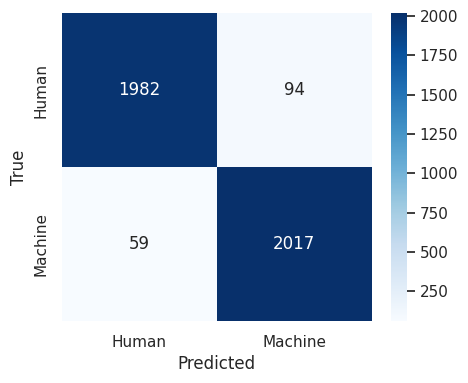

In [ ]:
model.eval()
with torch.no_grad():
    logits_test, _ = model(X_test_t)
    probs_test = torch.sigmoid(logits_test).cpu().numpy()
    preds_bin = (probs_test > 0.5).astype(int)

acc = accuracy_score(y_test, preds_bin)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, preds_bin, average="binary"
)

print("SFSC Results:")
print("Accuracy:", acc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

cm = confusion_matrix(y_test, preds_bin)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Human", "Machine"],
            yticklabels=["Human", "Machine"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

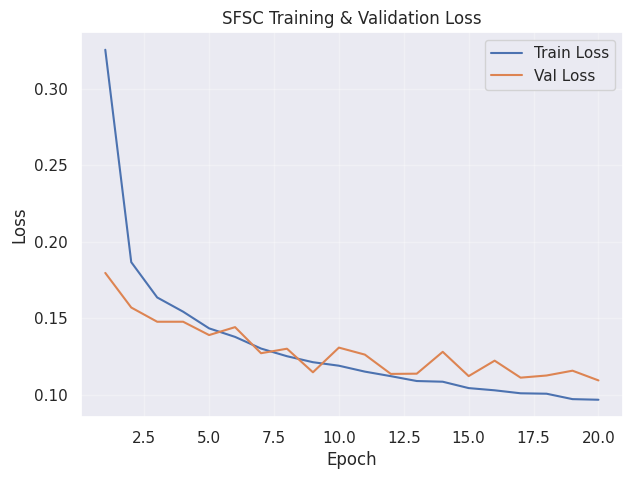

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SFSC Training & Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

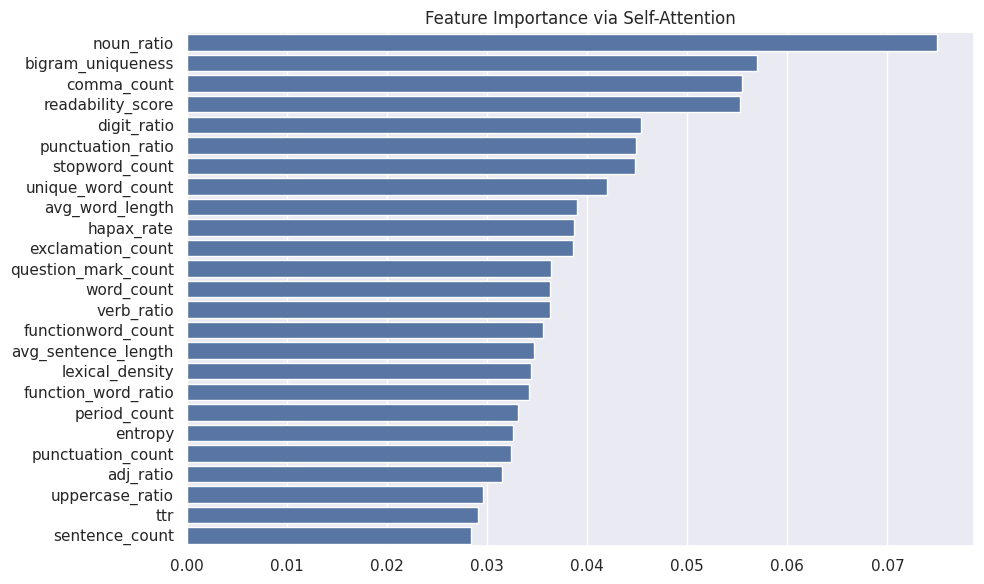

noun_ratio               : 0.0749
bigram_uniqueness        : 0.0570
comma_count              : 0.0555
readability_score        : 0.0553
digit_ratio              : 0.0454
punctuation_ratio        : 0.0449
stopword_count           : 0.0448
unique_word_count        : 0.0420
avg_word_length          : 0.0390
hapax_rate               : 0.0387
exclamation_count        : 0.0385
question_mark_count      : 0.0364
word_count               : 0.0363
verb_ratio               : 0.0362
functionword_count       : 0.0356
avg_sentence_length      : 0.0347
lexical_density          : 0.0344
function_word_ratio      : 0.0342
period_count             : 0.0331
entropy                  : 0.0325
punctuation_count        : 0.0324
adj_ratio                : 0.0314
uppercase_ratio          : 0.0296
ttr                      : 0.0291
sentence_count           : 0.0284


In [ ]:
model.eval()
with torch.no_grad():
    X_all_t = torch.tensor(X_all_s, dtype=torch.float32)
    _, att_weights_all = model(X_all_t)

mean_att = att_weights_all.mean(dim=0).cpu().numpy()

feature_names = feature_df.drop("label", axis=1).columns
order = np.argsort(mean_att)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_att[order], y=np.array(feature_names)[order])
plt.title("Feature Importance via Self-Attention")
plt.tight_layout()
plt.show()

for name, w in zip(np.array(feature_names)[order], mean_att[order]):
    print(f"{name:25s}: {w:.4f}")